**Author:** Thomas Lane, Zhanyuan Zhang  
**Purpose:** This script help calculate the false discovery rate and the C-statistics of a binary classification model.  
**Usage:** User needs to input the names of the model and its weights. Since all models should be saved in the *models* folder, this script by default imports model from that folder.

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utility import load_model
import pickle

In [12]:
# Input the name of the model and its weights
model_name = "adam_2019_01_29"
model_weights = "adam_2019_01_29_weights"

# Generate the path of the model and its weights
model_path = "models/" + model_name + ".json"
weights_path = "models/" + model_weights + ".h5"

In [13]:
model = load_model(model_path, weights_path)

Loaded model from models/adam_2019_01_29.json


**Before we calculate the FDR and C-statistics, we need to generate or import the input data and the correct labels**

In [14]:
# x_train = np.random.random((1000, 100))
# y_train = np.random.randint(2, size=(1000, 1))
with open("../data/new_list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)
    
seq_record_list = seq_record_list[:4800]
from random import shuffle
shuffle(seq_record_list)

In [15]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the end of the lst.
# 2. If len(lst) < read_len, keep extending the end of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0, 0, 0, 0, 0])
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [24]:
x_train, y_train, x_test, y_test = prepare_input(4800, 0, 1000)
x_train, y_train, x_test, y_test = to_np_array(x_train, y_train, x_test, y_test)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
[x_train.shape, y_train.shape]

[(4800, 1, 8000), (4800, 1, 1)]

In [27]:
x_train_rnn = x_train.reshape(4800, 1000, 8)

# False Discovery Rate
This cell uses the model to make predictions on our data.

Then it iterates through the results and the real labels and compares them to check for False Positives(FP) and True Positives(TP).

Then it uses the formula to calculate the False Discovery Rate (FDR)

In [28]:
results = model.predict(x_train_rnn, batch_size=16)

false_positives = 0
true_positives = 0
total_negatives = 0
total_positives = 0
true_negatives = 0

for i in range(0,results.size):
    
    if results[i][0]>=0.5 and y_train[i]==0:
        false_positives += 1

    if results[i][0]>=0.5 and y_train[i]==1:
        true_positives += 1
        
    if results[i][0]<=0.5 and y_train[i]==0:
        true_negatives += 1
        
    if results[i][0] <= 0.5:
        total_negatives += 1
        
    if results[i][0] >= 0.5:
        total_positives += 1

false_discovery_rate = false_positives/(false_positives + true_positives)
print("The false discovery rate is: {}".format(false_discovery_rate))

The false discovery rate is: 0.11462264150943396


# C-statistics
This cell iterates through the data using an incrementing threshold value to generate an ROC Curve then uses a Riemann sum (trapezoidal) to generate the C-statistic

ROC Curve


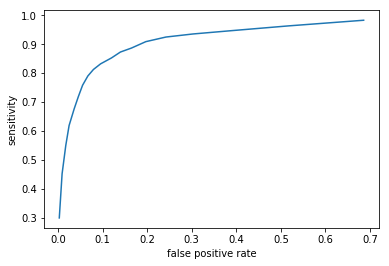

c-statistic = 0.6183236212866321


In [29]:
sensitivities = []
false_positive_rates =[]
discovery_percentage = 0.05

while discovery_percentage < 1.0:
    
    false_positives = 0
    true_positives = 0
    total_negatives = 0
    total_positives = 0
    true_negatives = 0
    
    for i in range(0,results.size):

        if results[i][0]>=discovery_percentage and y_train[i]==0:
            false_positives += 1

        if results[i][0]>=discovery_percentage and y_train[i]==1:
            true_positives += 1

        if results[i][0]<=discovery_percentage and y_train[i]==0:
            true_negatives += 1

        if y_train[i]==0:
            total_negatives += 1

        if y_train[i]==1:
            total_positives += 1
            
    if total_positives != 0 and total_negatives != 0:
        sensitivities.append(true_positives / total_positives)
        false_positive_rates.append(1-(true_negatives / total_negatives))
    
    discovery_percentage += 0.05
    
riemann = 0.0
for i in range(0,len(sensitivities) - 1):
    riemann += 0.5 * (sensitivities[i]+sensitivities[i+1]) * (false_positive_rates[i]-false_positive_rates[i+1])
    

print("ROC Curve")
plt.plot(false_positive_rates, sensitivities )
plt.ylabel('sensitivity')
plt.xlabel('false positive rate')
plt.show()
print("c-statistic = " + str(riemann))